# Detecció d'atacs de Ransomware


## AUTOR: DAVID SARDÀ MARTIN

## Introducció

En aquesta pràctica buscarem el millor model de classificació que donades alguns paràmetres de memòria ens permeti determinar si un dispositiu es troba sota un atac de Ransomware.

El dataset escollit és un dataset publicat per la Universitat de New Brunswick, anomenat CIC-MalMem-2022.

Per la creació del Dataset es va fer a partir de recollir mostres benignes, les mostres benignes són extretes a partir d'executar diverses aplicacions en una màquina simulant el comportament d'un usuari mitjà, i malignes, extretes de 2916 mostres de virus de VirusTotal amb diferents categories, entre les quals s'inclou Ransomware que serà la que ens interessa pel nostre projecte, en el mateix tipus de dispositiu.
El dataset fa un recull de diferents paràmetres de memòria per tal de veure si els atacs de malware ofuscat es poden detectar a partir de la memòria. Pels nostres objectius d'aquest projecte eliminarem les mostres que no corresponen a mostres benignes o d'atacs de Ransomware.

Començarem per analitzar les dades i les relacions entre elles, aplicarem les modificacions a les dades, posteriorment buscarem el millor model i buscarem els millors hiperparàmetres pel model seleccionat. A més es crearà un model de xarxa neuronal amb PyTorch i buscarem que ofereixi un molt bon rendiment de igual forma que els anteriors.

## Carregarem les dades i preprocessat

El primer pas es carregar el Dataset a partir del qual detectarem els atacs de Ransomware. Posteriorment, realitzarem les diferents transformacions al dataset per tal de facilitar al classificador la feina a realitzar i d'aquesta forma reduir els temps de convergència i test del model. Les transformacions també poden ajudar a obtenir millor resultats en quan el rendiment de l'algoritme però en aquest cas no es així.

Primerament mirem les dimensionalitat inicials del Dataset, que es mostren a continuació.
Les diferents transformacions aplicades són:


* Primer seleccionarem les dades benignes i de Ransomware únicament.
* Convertir la categoria objectiu (Class) en una variable numèrica, convertim les instancies Benign en 0 i les Malware en 1.
* Eliminem atributs que no aporten informació: 'Category', 'pslist.nprocs64bit', 'handles.nport', 'svcscan.interactive_process_services','callbacks.ngeneric', 'callbacks.nanonymous', 'pslist.avg_handlers', 'ldrmodules.not_in_mem', 'ldrmodules.not_in_load_avg','malfind.protection', 'psxview.not_in_pslist',  'psxview.not_in_session_false_avg' i 'psxview.not_in_csrss_handles'.
    


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc, precision_score, recall_score

def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

dataset_predir = load_dataset('../data/Obfuscated-MalMem2022.csv')


dataset_benign = dataset_predir[(dataset_predir['Category'].astype(str).str.startswith('Benign'))]
print("Dimensionalitat Benignes:", dataset_benign.shape)

dataset_ransom = dataset_predir[(dataset_predir['Category'].astype(str).str.startswith('Ransomware'))]

print("Dimensionalitat Ransomwares:", dataset_ransom.shape)



dataset_predir = pd.concat([dataset_benign, dataset_ransom])


dataset_predir=dataset_predir.drop(['Category'], axis=1) #La classe categoria i classe ja no aporten informació diferent no té sentit conservar les dos, les dues es poden identificar com objectiu, no té sentit predir que una instancia es malware sabent que es Ransomware.
dataset_predir['Class'] = dataset_predir['Class'].replace(['Benign','Malware'],[0,1]) #convertim el malware i programes benignes en 0 i 1, es més fàcil treballar amb valors numèrics


dataset_predir=dataset_predir.drop(['pslist.nprocs64bit', 'handles.nport', 'svcscan.interactive_process_services','callbacks.ngeneric', 'callbacks.nanonymous'], axis=1)


dataset_predir=dataset_predir.drop(['pslist.avg_handlers', 'ldrmodules.not_in_mem', 'ldrmodules.not_in_load_avg',
                                    'malfind.protection', 'psxview.not_in_pslist',  'psxview.not_in_session_false_avg',
                                    'psxview.not_in_csrss_handles'], axis=1)





Dimensionalitat Benignes: (29298, 57)
Dimensionalitat Ransomwares: (9791, 57)


## Analisi del Dataset

Passarem a veure diferents característiques de Dataset. Primerament observarem el tipus de dades del Dataset, es pot observar que ara totes les variables del Dataset són numèriques, algunes són decimals (floats) i altres són enters (int).

In [9]:
print("Posteriorment mirarem el tipus de dades que tenim")
print(dataset_predir.dtypes)

Posteriorment mirarem el tipus de dades que tenim
pslist.nproc                                int64
pslist.nppid                                int64
pslist.avg_threads                        float64
dlllist.ndlls                               int64
dlllist.avg_dlls_per_proc                 float64
handles.nhandles                            int64
handles.avg_handles_per_proc              float64
handles.nfile                               int64
handles.nevent                              int64
handles.ndesktop                            int64
handles.nkey                                int64
handles.nthread                             int64
handles.ndirectory                          int64
handles.nsemaphore                          int64
handles.ntimer                              int64
handles.nsection                            int64
handles.nmutant                             int64
ldrmodules.not_in_load                      int64
ldrmodules.not_in_init                      int64


Un altre element que és important considerar és si hi ha dades nules, si en el dataset hi ha dades que són nul·les caldrà fer algun tractament sobre elles, com pot ser substituir-les per la mitjana, substituir-les per una mitja amb soroll, eliminar-les...

Pel nostre cas en particular es pot observar que no tenim mostres nul·les de forma que no caldrà fer cap transformació dels elements nuls.

In [10]:
print("Aixó com també observarem el nombre de dades nules que tenim")
print(dataset_predir.isnull().sum())



Aixó com també observarem el nombre de dades nules que tenim
pslist.nproc                              0
pslist.nppid                              0
pslist.avg_threads                        0
dlllist.ndlls                             0
dlllist.avg_dlls_per_proc                 0
handles.nhandles                          0
handles.avg_handles_per_proc              0
handles.nfile                             0
handles.nevent                            0
handles.ndesktop                          0
handles.nkey                              0
handles.nthread                           0
handles.ndirectory                        0
handles.nsemaphore                        0
handles.ntimer                            0
handles.nsection                          0
handles.nmutant                           0
ldrmodules.not_in_load                    0
ldrmodules.not_in_init                    0
ldrmodules.not_in_init_avg                0
ldrmodules.not_in_mem_avg                 0
malfind.ninject

Un cop fetes totes les transformacions també podem observar quines són les dimensionalitats finals del Dataset:

In [11]:
print("Seleccionem la variable objectiu i mirarem les dimensionalitats de les nostres dades")
data = dataset_predir.values
print("Dimensionalitat de la BBDD:", dataset_predir.shape)
x = data[:, :-1]
y = data[:, -1]


print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

Seleccionem la variable objectiu i mirarem les dimensionalitats de les nostres dades
Dimensionalitat de la BBDD: (39089, 44)
Dimensionalitat de les entrades X (39089, 43)
Dimensionalitat de l'atribut Y (39089,)


Sovint és útil observar la matriu de correlacions del Dataset, això ens permet fer-nos una idea dels atributs del Dataset i com estan de relacionades entre elles, per exemple per aqeust Dataset amb particular la majoria d'atributs eliminats prèviament es van fer d'acord a aquesta matriu, ja que hi havien elements directament o inversament correlacionats totalment, el que implicava que ambdós aportaven la matexia informació, de forma que es van eliminar. 

Posteriorment es va comprovar si els elements, afectaven en la predicció, però es va poder observar que els algoritmes funcionaven en general més ràpidament un cop eliminats aquests atributs correlacionats.

Un cop començades a veure les dades passarem a observar les distribucions i relacions que considerem interessants
Primer observarem la matriu de correlació dels atributs


<Figure size 432x288 with 0 Axes>

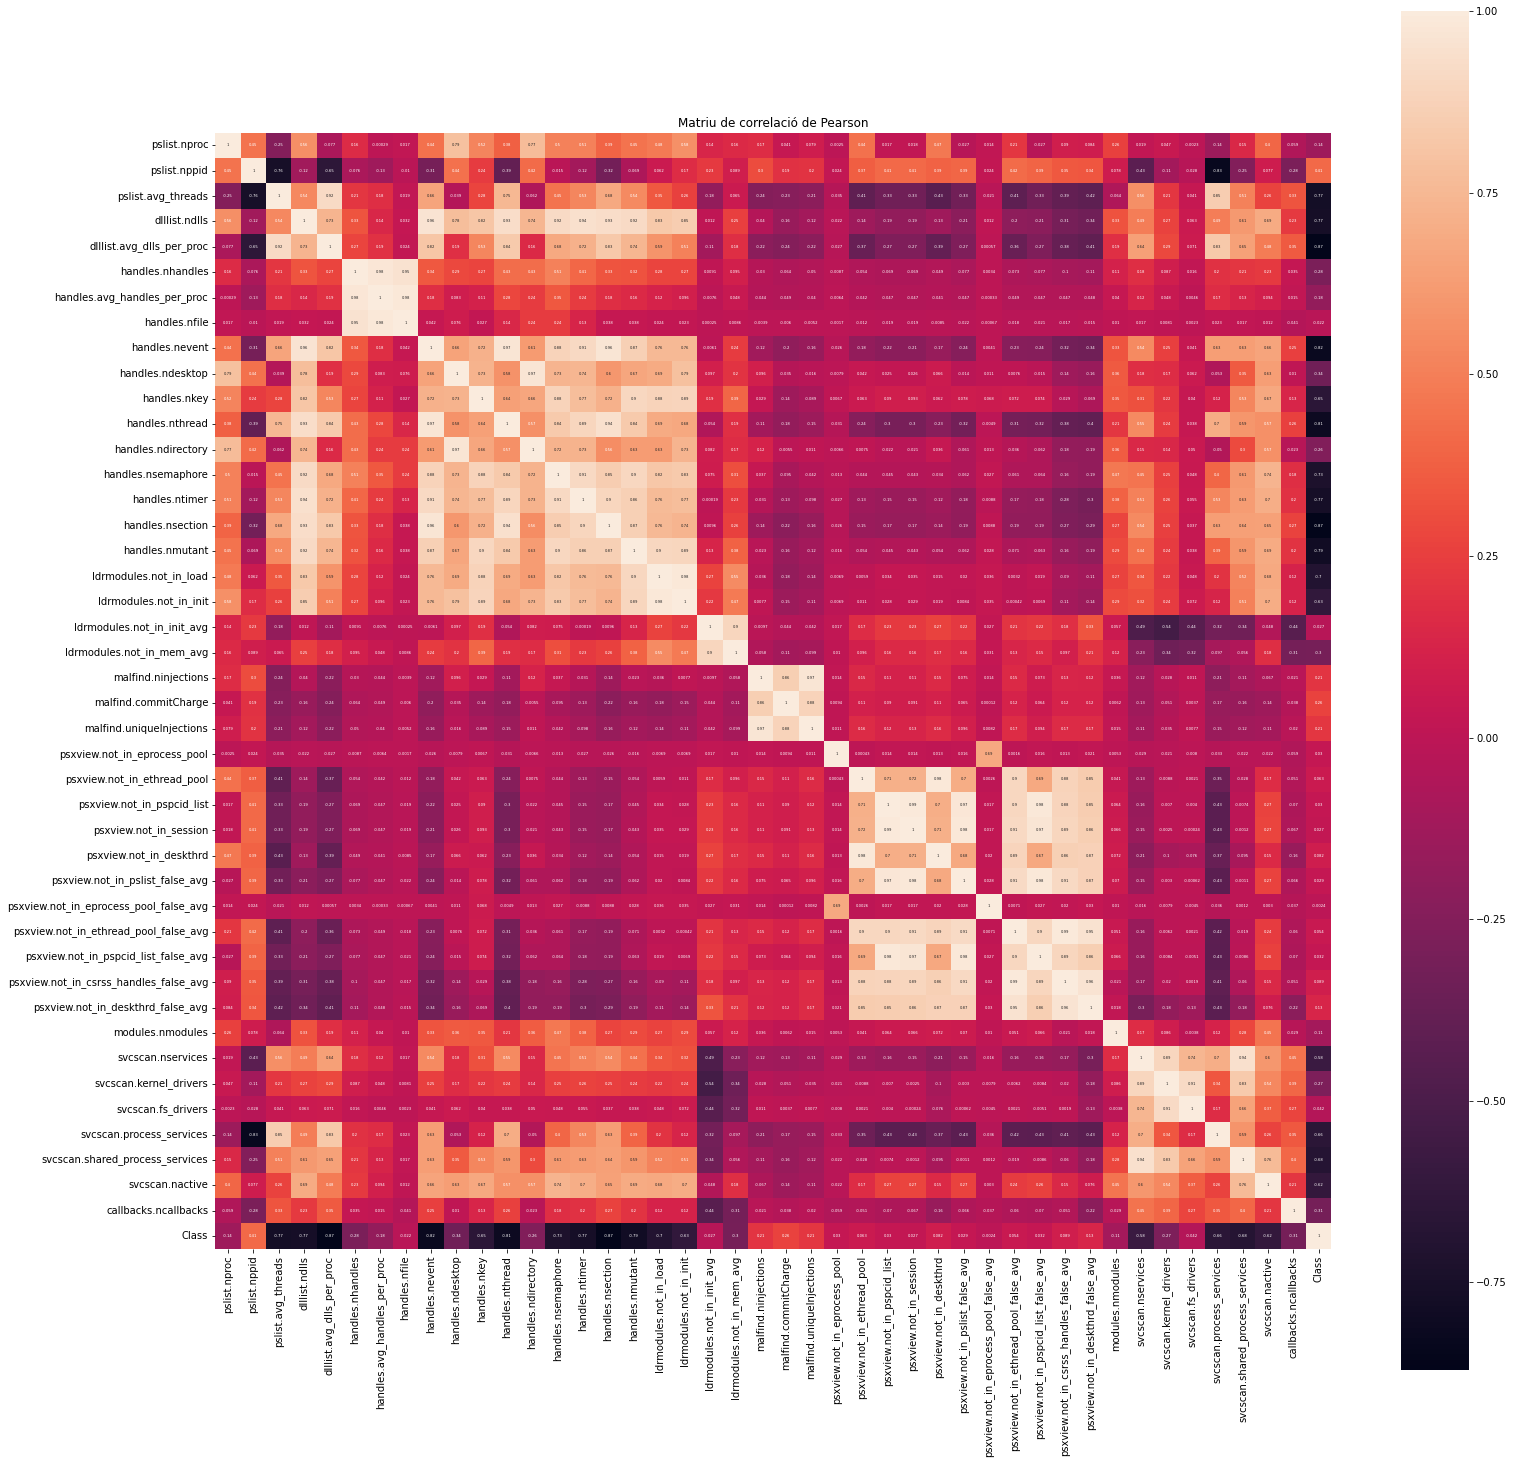

In [12]:
print("Un cop començades a veure les dades passarem a observar les distribucions i relacions que considerem interessants")
print("Primer observarem la matriu de correlació dels atributs")
plt.figure()
fig, ax = plt.subplots(figsize=(25, 25))  # figsize controla l'amplada i alçada de les cel·les de la matriu
plt.title("Matriu de correlació de Pearson")
sns.heatmap(dataset_predir.corr(), annot=True, ax=ax, linewidths=.0, annot_kws={"fontsize": 750 / np.sqrt(len(dataset_predir))}, square=True)

plt.show()


Ara passarem a observar la distribució de la variable objectiu, per fer prediccions ens interessarà que les classes de la variable objectiu estiguin balancejades i si no és així caldrà tindre en compte com de balancejades estan. Per entendre-ho millor veiem un exemple, si per exemple tenim 100 persones de les quals 20 tenen la Covid i es crea un test d'antígens, ens interessarà que pugui detectar si tenen o no, si el test d'antígens que es crea diu sempre que la persona no té covid voldrà dir que tindrà un 80% d'encert, però realment no detectarà la covid, per tant, és una mala pràctica. És per això, que cal fixar-se en les distribucions de la variable objectiu i tenir-les en compte. En el nostre cas, podem veure en la Figura 2, que el percentatge de mostres que són benignes representa un 74.95% del total de dades, mentre que el percentatge de mostres que són ransomware en representa un 25.05%.


El percentatge de mostres que son bemignes representa un 74.95% del total de dades
El percentatge de mostres que son malware representa un 25.05% del total de dades


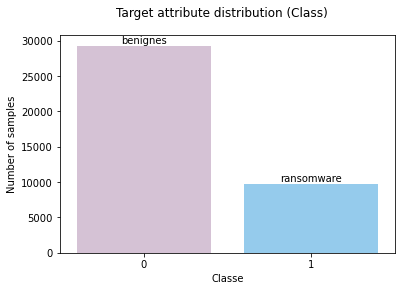

In [13]:

    porc_pot = (len(dataset_predir[dataset_predir.Class == 0]) / len(dataset_predir.Class)) * 100
    print('El percentatge de mostres que son bemignes representa un {:.2f}% del total de dades'.format(porc_pot))
    porc_pot = (len(dataset_predir[dataset_predir.Class == 1]) / len(dataset_predir.Class)) * 100
    print('El percentatge de mostres que son malware representa un {:.2f}% del total de dades'.format(porc_pot))

    

    ax = sns.countplot(x="Class", data=dataset_predir, palette={0: 'thistle', 1: "lightskyblue"})
    plt.suptitle("Target attribute distribution (Class)")
    label = ["benignes", "ransomware"]
    ax.bar_label(container=ax.containers[0], labels=label)
    plt.xlabel('Classe')
    plt.ylabel('Number of samples')
   
    plt.show()

## Sel·lecció de model

És important seleccionar el model adequat, per l'elecció del model hi ha diferents mètriques i paràmetres que es poden tenir en compte: precisió, taxa encerts, recall, temps de test, temps de convergència. En el nostre cas les eleccions s'han fet en base el temps de test i a la recall, d'aquesta forma teniem en compte la distribució no uniforme de la variable objectiu i també la importància de sel·lecionar un model que pugui predir ràpidament si hi ha un atac de Ransomware per una ràpida resposta. 

Els models que van apareixer amb millor rendiment en base aquestes mètriques van ser: SVM polinòmic i HstGradientBoosting. D'aquesta forma es van optimitzar aquests model amb l'algoritme Randomized Search per trobar els millor paràmetres pels models i es van obtenir els següents resultats:

In [14]:
models = []

models.append(('HistGradientBoosting optimitzat', make_pipeline(MinMaxScaler(), HistGradientBoostingClassifier(l2_regularization=1.0407479858562003e-05,
                               learning_rate=0.08115041228011703, max_bins=84,
                               max_iter=200, max_leaf_nodes=83,
                               min_samples_leaf=95))))
models.append(('SVM polinomi optimitzat', make_pipeline(MinMaxScaler(), SVC(C=257.445884056174, class_weight='balanced', gamma=0.18325543501264982,
    kernel='poly', probability=True))))

# DEFINE THE METRICS

scoring = ['balanced_accuracy','f1_weighted',  'recall_weighted',  'roc_auc_ovr_weighted']
estimator=0
# CREATE AND PROVE THE MODELS

for index, (name, model) in enumerate(models):
    K_Fold = model_selection.KFold (n_splits = 6, shuffle=True)
    cv_results = model_selection.cross_validate (model, x, y, cv = K_Fold, scoring = scoring, return_estimator=True)
    message =  "%s,  dades (%f):  accuracy: %f (%f),  f1: %f, recall: %f, roc: %f, temps convergir algoritme %f, i temps test: %f " % (name, 6,cv_results['test_balanced_accuracy'].mean(),
                                    cv_results['test_balanced_accuracy'].std(),  cv_results['test_f1_weighted'].mean(), cv_results['test_recall_weighted'].mean(),
                                    cv_results['test_roc_auc_ovr_weighted'].mean(), cv_results['fit_time'].mean(),  cv_results['score_time'].mean())

    print (message)



HistGradientBoosting optimitzat,  dades (6.000000):  accuracy: 0.999966 (0.000048),  f1: 0.999949, recall: 0.999949, roc: 0.999997, temps convergir algoritme 1.104240, i temps test: 0.064171 
SVM polinomi optimitzat,  dades (6.000000):  accuracy: 0.999933 (0.000111),  f1: 0.999949, recall: 0.999949, roc: 1.000000, temps convergir algoritme 1.465789, i temps test: 0.023373 


Observarem també altres paràmetres que ens ajudaran a veure com el nostre algoritme funciona i a on falla, per exemple la matriu de confusió. Primer observarem pel model HistGradientBoosting algunes mètriques més:

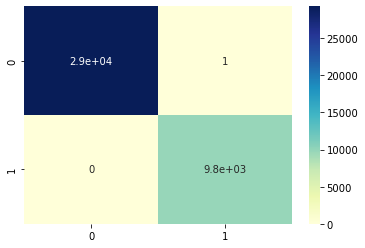

In [15]:
clf1=HistGradientBoostingClassifier(l2_regularization=1.0407479858562003e-05,
                               learning_rate=0.08115041228011703, max_bins=84,
                               max_iter=200, max_leaf_nodes=83,
                               min_samples_leaf=95)
clf2=SVC(C=257.445884056174, class_weight='balanced', gamma=0.18325543501264982,
    kernel='poly', probability=True)



probs_hgb = cross_val_predict(clf1, x, y, cv=6, method='predict_proba')

y_pred1 = cross_val_predict(clf1, x, y, cv=6)
conf_mat = confusion_matrix(y, y_pred1)

plt.figure()
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu")

plt.show()




Es pot veure que ja s’ha aconseguit models amb molt bon rendiment i que les diferents mètriques s’aproximen molt a la perfecció, però no arriben a la perfecció per evitar l’overfitting.

Altres mètriques que es poden observar són la corba ROC i la corba de precision-recall.


In [16]:
def analisi_res(probs,y,name):

    # PLOT THE PRECISION-RECALL CURVE

    precision = {}
    recall = {}
    average_precision = {}
    plt.figure()
    n_classes=2
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y== i, probs[:, i])
        average_precision[i] = average_precision_score(y == i, probs[:, i])

        plt.plot(recall[i], precision[i],
                 label='Precision-recall curve of class {0} (area = {1:0.2f})'
                       ''.format(i, round(average_precision[i])))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="upper right")
    plt.title("Precision-recall curve for {} model".format(name))
    plt.savefig("../figures/corba_precision_recall_{}.png".format(name))
    plt.show()


    # PLOT THE ROC CURVE

    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y== i, probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])



    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
    plt.title("ROC curve for {} model".format(name))
    plt.legend()
    plt.savefig("../figures/corba_roc_{}.png".format(name))
    plt.show()


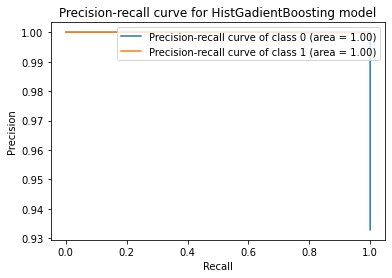

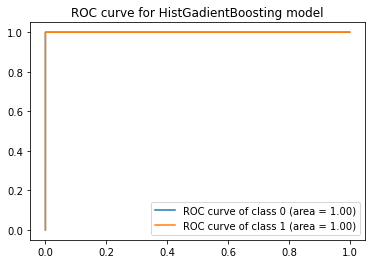

In [17]:
analisi_res(probs_hgb,y,'HistGadientBoosting')


Ara veurem els resultats pel cas del model SVM, es pot veure també el bon rendiment d'ell amb la matriu de confusió, la corba ROC i la corba de precision recall.

[[29298     0]
 [    9  9782]]


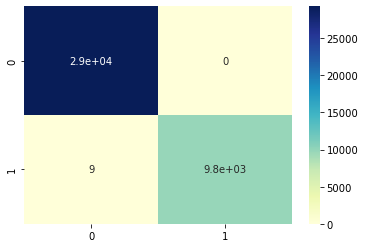

In [18]:

probs_svm = cross_val_predict(clf2, x, y, cv=6, method='predict_proba')

y_pred2 = cross_val_predict(clf2, x, y, cv=6)
conf_mat = confusion_matrix(y, y_pred2)
print(conf_mat)
plt.figure()
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu")

plt.show()

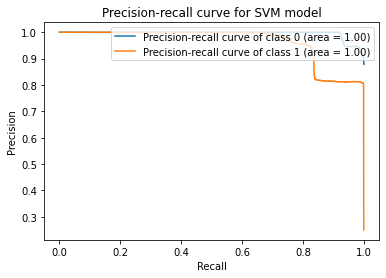

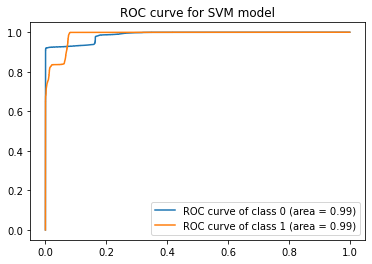

In [19]:
analisi_res(probs_svm,y,'SVM')

## XARXA NEURONAL

En aquesta secció es passarà a parlar de la xarxa neuronal que s'ha creat amb Tensors. Per crear la xarxa neuronal primer s'ha procedit a entendre com funcionen els Tensors i com es poden utilitzar per crear una xarxa neuronal, posteriorment s'ha provat el seu funcionament amb un dataset molt conegut i que ofereix la pròpia llibreria de sklearn amb la que hem provat altres models, la llibreria d'iris. Finalment, s'ha creat una xarxa neuronal pel nostre dataset en concret.



### CONSIDERACIONS DE LA XARXA NEURONAL

Per a crear la xarxa neuronal s'han hagut de triar alguns aspectes que a continuació veurem quins han sigut:

* Número d'Epochs: que defineixen les iteracions que donem al model per convergir amb el conjunt d'entrenament, a major número d'EPOCHS més temps tardarà a convergir l'algoritme, però podem aconseguir un model amb millor rendiment. Pel nostre cas amb 1000 ha sigut suficient perquè l'algoritme convergeixi, tot i que cal tenir en compte que depèn de l'execució pot oferir resultats diferents o pot arribar a no convergir.

* Nombre de capes ocultes de la xarxa neuronal: a major número d'EPOCHS més temps trigarà a fer prediccions i convergir l'algoritme, però podem obtenir un model amb millor rendiment.

* Optimització: Per a l'optimització de paràmetres s'ha triat el model SGD (Stochastic gradient descent) que intenta buscar el mínim global, en lloc de conformar-se amb un mínim local i per aconseguir-ho fa alguns càlculs redundants.

* Funció de pèrdues: Cal definir una funció de pèrdues per definir com penalitzen les mostres que és predeixin malament en l'entrenament, per tal de decidir si un model és millor o pitjor que un altre. Pel nostre model hem seleccionat l'entropia amb un balanceig de pesos, que permetrà tindre en compte les distribucions de les variables de sortida, es donarà més pes als errors i encerts en les que la mostra a predir sigui menys freqüent. L'entropia es pot calcular com:

H(X)= −∑pi×log2(pi)




Per la creació de la xarxa neuronal s’ha iniciat amb cap capa oculta i aumentar poc tan els nodes com el nombre de capes ocultes. S'han fet diferents proves i la que ha obtingut millors resultats tenint en compte la precisió i el temps ha sigut amb la xarxa tenint la següent forma:

* Capa entrada: 43 entrades d’entrada (que corresponen a les 43 característiques del dataset) i 50 sortides
* 1a capa oculta: 50 entrades i 100 sortides
* 2a copa oculta: 100 entrades i 200 sortides
* Capa sortida: 200 entrades i 2 sortides (que corresponen a les 2 possibles classificacions de cada instància)


S'han definit per aconseguir EPOCHS=1000 perquè l'algoritme arribi a convergir, s'aconsegueix amb aquest algoritme una precisió del 99,136%, tot i que depenen de la iteració pot oscil·la entre aquesta i un 70%, quan l'algoritme no convergeix. A continuació es pot veure la creació i definició de la xarxa neuronal.





In [108]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class XarxaNeuronal(nn.Module):


    def __init__(self, in_size, out_size):
        super().__init__()  # Call the init function of nn.Module
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(in_size, 50)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, 25)
        self.fc4 = nn.Linear(25, out_size)

    def forward(self, x):

        # add 1st hidden layer, with relu activation function
        out= self.fc1(x.float())
        out = F.leaky_relu(out)

        # add 2nd hidden layer, with relu activation function
        out = F.leaky_relu(self.fc2(out))

        # add dropout layer
        out = self.dropout(out)

        # add 3rd hidden layer, with relu activation function
        out = F.leaky_relu(self.fc3(out))

        # add output layer, with relu activation function
        out = F.leaky_relu(self.fc4(out))

        return out


Definim el model:

In [139]:



X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)



model=XarxaNeuronal(43,2)  # create the model
nSamples = [len(y[y == 0]), len(y[y == 1])]
normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
normedWeights = torch.FloatTensor(normedWeights)
optimizer = torch.optim.SGD(list(model.parameters()) + list(normedWeights), lr=0.001, momentum=0.9) #define the optimizator


loss_fn = nn.CrossEntropyLoss(weight=normedWeights.float()) #define the los function


X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test = Variable(torch.from_numpy(X_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()


Entrenem el model:

In [140]:
import time


EPOCHS = 1000 #Number of iterations to train the model


loss_list = np.zeros((EPOCHS,))
accuracy_list_train = np.zeros((EPOCHS,))
accuracy_list_test  = np.zeros(EPOCHS)
n_classes=2
elapsed=0
elapsed_train=0
start_train = time.time()
for epoch in tqdm.trange(EPOCHS):

    y_pred = model.forward(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss

    correct = (torch.argmax(y_pred, dim=1) == y_train).type(torch.FloatTensor)
    accuracy_list_train[epoch] = correct.mean()

    # Zero gradients
    optimizer.zero_grad()
    #recalculate with backpropagation
    loss.backward()
    #actualizate the weights
    optimizer.step()
    #if (epoch + 1) % 50 == 0:
    #    print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {loss:.4f}, Test Loss: {loss_test.item():.4f}")


    with torch.no_grad():  #Prediction of the model with the test isntances


        start = time.time()

        y_pred = model(X_test)
        y_pred_class=torch.argmax(y_pred, dim=1)
        correct = (y_pred_class == y_test).type(torch.FloatTensor)

        done = time.time()
        elapsed = done - start




        accuracy_list_test[epoch] = correct.mean()
        y_pred_num=np.array(y_pred)

done_train = time.time()

100%|███████████████████████████████████████| 1000/1000 [00:55<00:00, 18.17it/s]


A continuació es pot veure l'evolució de l'accuracy al llarg de les iteracions dels diferents conjunts d'entrenament i test, en la següent figura, es pot veure com ja ha convergit al final pel nombre d'iteracions utilitzat:

Ara avaluarem el rendiment de la xarxa neuronal
La taxa encert final de les dades d'entrenament és: 0.9887755513191223
La taxa encert final de les dades de test és 0.9869531989097595
F1: 0.9741641337386018
Precision: 0.9552906110283159
Recall: 0.993798449612403
Temps en predir: 0.005301237106323242
Temps en entrenar: 55.03273296356201


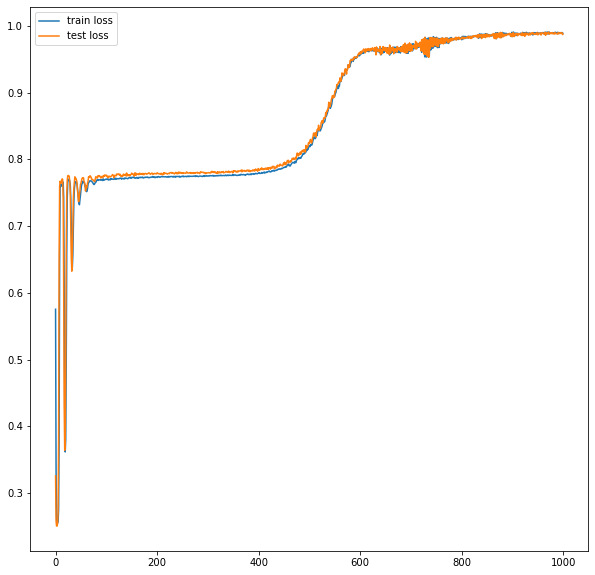

In [141]:

print("Ara avaluarem el rendiment de la xarxa neuronal")

print("La taxa encert final de les dades d'entrenament és:", accuracy_list_train[-1])
print("La taxa encert final de les dades de test és", accuracy_list_test[-1])

print('F1: {}'.format(f1_score(y_test.numpy(), y_pred_class.numpy())))
print('Precision: {}'.format(precision_score(y_test.numpy(), y_pred_class.numpy())))
print('Recall: {}'.format(recall_score(y_test.numpy(), y_pred_class.numpy())))
print("Temps en predir:" , elapsed)
elapsed_train = done_train - start_train
print("Temps en entrenar:" , elapsed_train)



# PLOT THE EVOLUTION OF THE ACCURACY

plt.figure(figsize=(10,10))
plt.plot(accuracy_list_train, label='train loss')
plt.plot(accuracy_list_test, label='test loss')
plt.legend()

plt.show()


També, per veure en més detall els resultats i analitzar-lo podem veure en la següent figura la matriu de confusió, on es pot veure que per ambdues categories s’estan aconseguint percentualment una gran quantitat d’encerts tot i que amb més errors que amb els models de sklearn seleccionats que hem vist anteriorment.


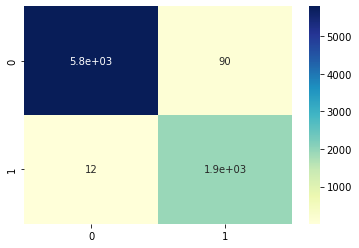

In [142]:
pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability


# PLOT THE CONFUSION MATRIX

conf_mat = confusion_matrix(y_test, pred)


plt.figure()
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu")
#plt.savefig("../figures/confusion_matrix_XarxaNeuronal_Ransom.png")
plt.show()

## Conclusions

Els atacs de Ransomware poden tenir conseqüències molt greus per les víctimes, ja siguin persones o institucions, poden bloquejar l’accés a dispositius, robar dades o bloquejar tots els serveis informàtics d’una organització. El que pot comportar grans pèrdues econòmiques o del dret a la privacitat. Els atacs de Ransomware són del tipus malware ofuscat, és a dir que es mantenen ocults en el sistema sense que l’usuari se n’adoni, addicionalment això són atacs que al llarg del temps evolucionen i segueixen nous patrons de forma que són molt complicats de detectar. A causa d’això, van aparèixer nombrosos estudis per detectar aquest tipus d’atac per poder posteriorment respondre’n. En aquest projecte s’han creat models per detectar atacs de Ransomware que ofereixen un molt bon rendiment, tan en temps per comprovar com en la precisió per detectar-lo.

Al final del projecte hem vist que els diferents objectius marcats s’han assolit satisfactòriament. S’han creat un model SVM i un model HistoGradientBoosting per predir atacs de Ransomware amb un percentatge d’encert superior al 99%, a més també s’ha creat una Xarxa Neuronal amb dues capes ocultes que ens donava també una tassa d’encert similar, i a més ens oferia millores pel que fa al temps de predicció. Per realitzar el treball, s’ha entès amb més aprofundiment el funcionament, els algorismes i paràmetres del Machine Learning i com treballar amb ells. 

